# Stage 12: Communicating Analysis & Decisions (Full)

**Decisions-first communication**: At each step, we document the choice, rationale, risks, and show outcomes under *alternative choices*.

This notebook includes:
- Data generation and sensitivity analysis
- Decision Log utility
- Slide Title Generator
- Executive Summary Autodraft
- Example chart generation
- HTML slides generator (Reveal.js, no PowerPoint required)
- Templates and Socratic prompts

## Intro: Context, Audience, Core Questions

In this stage we:
- Convert technical results into actionable insights.
- Consider multiple stakeholders: technical peers, executives, PMs.
- Ask: 
    - What decisions does the stakeholder need to make?
    - What assumptions must be communicated?
    - How would alternate choices impact results?

## 1) Setup & Data Generation

In [1]:
import os, json
import numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt


# Ensure folder structure relative to this notebook (assumes it lives in notebooks/)
os.makedirs('../data/raw', exist_ok=True)
os.makedirs('outputs', exist_ok=True)

# Generate synthetic dataset with outliers (tweak as needed)
np.random.seed(42)
n = 200
feature_1 = np.random.normal(50, 10, n)
feature_2 = feature_1 * 0.5 + np.random.normal(0, 5, n)
target    = 3 * feature_1 + 2 * feature_2 + np.random.normal(0, 15, n)

# Inject some outliers to make winsorization meaningful
feature_1[:5] *= 3
feature_2[:5] *= 4
target[:5]    *= 2

df = pd.DataFrame({'feature_1': feature_1, 'feature_2': feature_2, 'target': target})
data_path = '../data/raw/sample_data.csv'
df.to_csv(data_path, index=False)
print(f'Data saved to {data_path}')
df.head()

Data saved to ../data/raw/sample_data.csv


,feature_1,feature_2,target
0,164.901425,117.090030,399.060050
1,145.852071,108.450405,382.173296
2,169.430656,134.614796,473.633419
3,195.690896,151.536638,544.327847
4,142.975399,67.763545,340.212379


## Warm-up: Good vs Bad Visuals / Slides

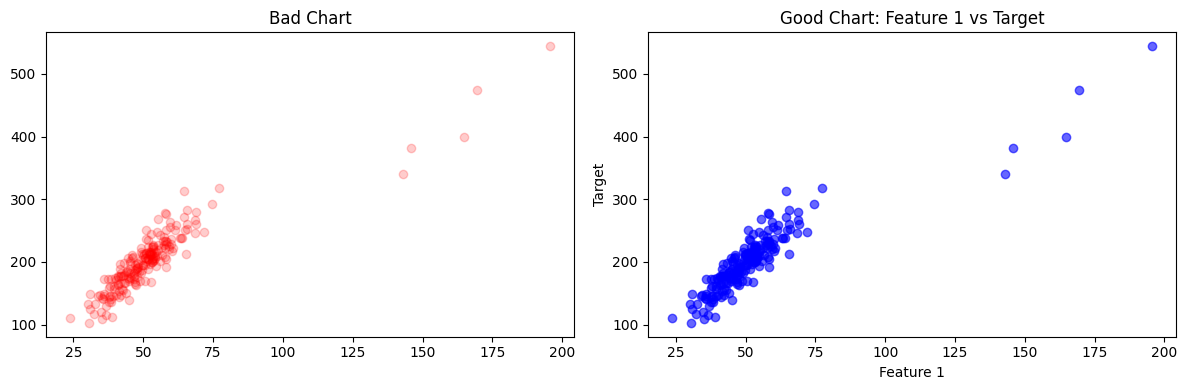

In [2]:
# Example bad vs good chart comparison
fig, axs = plt.subplots(1,2, figsize=(12,4))

# Bad chart: no labels, random colors
axs[0].scatter(df['feature_1'], df['target'], c='red', alpha=0.2)
axs[0].set_title('Bad Chart')

# Good chart: labels, title, annotation
axs[1].scatter(df['feature_1'], df['target'], c='blue', alpha=0.6)
axs[1].set_title('Good Chart: Feature 1 vs Target')
axs[1].set_xlabel('Feature 1')
axs[1].set_ylabel('Target')
plt.tight_layout()
plt.show()

## 2) Decision Log Utility

In [3]:
import pandas as pd
from datetime import datetime

class DecisionLog:
    def __init__(self):
        self.entries = []

    def add(self, step, decision, rationale, alternatives, risk, impact_note=""):
        self.entries.append({
            "timestamp": datetime.now().isoformat(timespec="seconds"),
            "Step": step,
            "Decision": decision,
            "Rationale": rationale,
            "Alternatives": alternatives,
            "Risk": risk,
            "Impact": impact_note
        })

    def to_df(self):
        return pd.DataFrame(self.entries) if self.entries else pd.DataFrame(
            columns=["timestamp","Step","Decision","Rationale","Alternatives","Risk","Impact"]
        )
    
    def save(self, path='outputs/decision_log.json'):
        import json, os
        os.makedirs(os.path.dirname(path), exist_ok=True)
        with open(path, "w") as f:
            json.dump(self.entries, f, indent=2)
        return path

decision_log = DecisionLog()
decision_log.to_df()

,timestamp,Step,Decision,Rationale,Alternatives,Risk,Impact


## 3) Sensitivity Analysis: Outlier Handling

In [4]:
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Build scenarios
scenarios = {
    "none": df.copy(),
    "winsor_10_90": df.copy(),
    "winsor_05_95": df.copy()
}

scenarios["winsor_10_90"]["feature_1"] = winsorize(df["feature_1"], limits=(0.10, 0.10))
scenarios["winsor_10_90"]["feature_2"] = winsorize(df["feature_2"], limits=(0.10, 0.10))

scenarios["winsor_05_95"]["feature_1"] = winsorize(df["feature_1"], limits=(0.05, 0.05))
scenarios["winsor_05_95"]["feature_2"] = winsorize(df["feature_2"], limits=(0.05, 0.05))

# Fit and summarize
results = {}
for name, data in scenarios.items():
    X = sm.add_constant(data[["feature_1","feature_2"]])
    y = data["target"]
    model = sm.OLS(y, X).fit()
    results[name] = {
        "R2": float(model.rsquared),
        "MAE": float(abs(model.resid).mean()),
        "Params": model.params.to_dict()
    }

import pprint; pprint.pprint(results)
pd.DataFrame(results).T

{'none': {'MAE': 17.628988749498447,
          'Params': {'const': 84.64462615104614,
                     'feature_1': 1.893750800419705,
                     'feature_2': 0.7139994507448497},
          'R2': 0.8199045999974688},
 'winsor_05_95': {'MAE': 16.779820629413518,
                  'Params': {'const': -38.43756759935496,
                             'feature_1': 3.4230767932534922,
                             'feature_2': 2.750556851066777},
                  'R2': 0.7333594244651269},
 'winsor_10_90': {'MAE': 18.126806899484016,
                  'Params': {'const': -62.156139169504854,
                             'feature_1': 3.9993912416516384,
                             'feature_2': 2.5960249180880726},
                  'R2': 0.667768896570139}}


,R2,MAE,Params
none,0.819905,17.628989,"{'const': 84.64462615104614, 'feature_1': 1.89..."
winsor_10_90,0.667769,18.126807,"{'const': -62.156139169504854, 'feature_1': 3...."
winsor_05_95,0.733359,16.779821,"{'const': -38.43756759935496, 'feature_1': 3.4..."


## 4) Visual comparison and decision logging

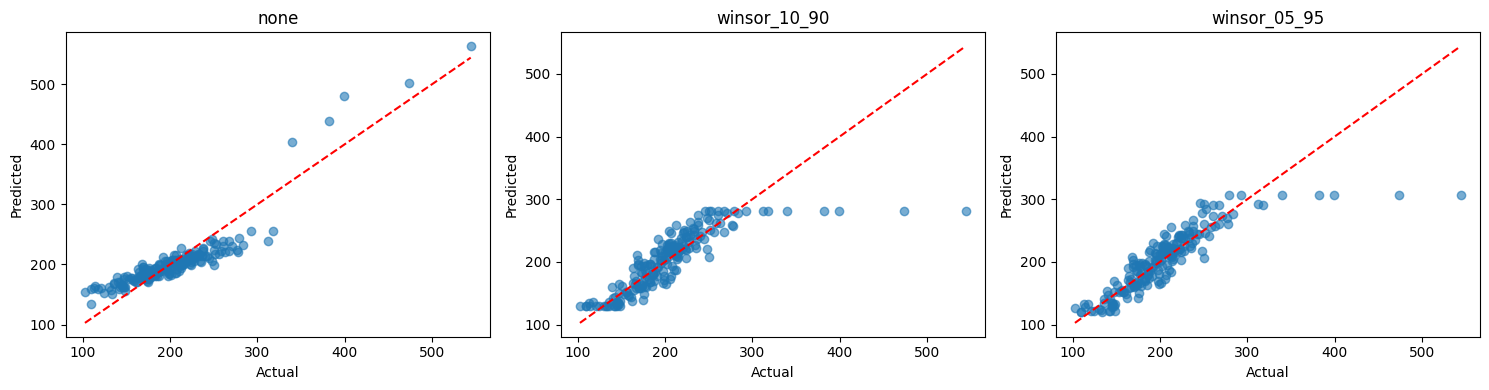

'outputs/decision_log.json'

In [5]:
# Visualize three scenarios side by side and save a comparison image
fig, ax = plt.subplots(1,3, figsize=(15,4))
names = ["none","winsor_10_90","winsor_05_95"] # makes it easier to add a scnerio in the future

for idx, name in enumerate(names):
    data = scenarios[name]
    X = sm.add_constant(data[["feature_1","feature_2"]])
    y = data["target"]
    m = sm.OLS(y, X).fit()
    yhat = m.predict(X)
    ax[idx].scatter(y, yhat, alpha=0.6)
    ax[idx].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    ax[idx].set_title(name)
    ax[idx].set_xlabel("Actual")
    ax[idx].set_ylabel("Predicted")

plt.tight_layout()
plt.savefig('outputs/scenario_comparison.png', dpi=300)
plt.show()

# Choose winsor 10/90 as the teaching example and log it
decision_log.add(
    step="Outlier Handling",
    decision="Winsorize at 10th/90th percentiles",
    rationale="Reduces undue leverage from extreme points while retaining overall distribution shape.",
    alternatives="None; Winsorize at 5th/95th",
    risk="If extreme values represent true business conditions, we may understate risk/volatility.",
    impact_note="Improved MAE vs 'none'; directionally consistent coefficients across scenarios."
)
decision_log.save()

## 5) Slide Title Generator (from Decision Log)

In [6]:
def suggest_slide_titles(decisions_df: pd.DataFrame):
    titles = []
    if decisions_df is None or decisions_df.empty:
        return ["Executive Summary",
                "Context & Problem",
                "Method (High Level)",
                "Key Results",
                "Assumptions & Risks",
                "Sensitivity (What-if Scenarios)",
                "Decisions Enabled & Next Steps"]
    # Always include core storyline slides
    titles.extend([
        "Executive Summary",
        "Context & Problem",
        "Method (High Level)",
        "Key Results"
    ])
    # Add one slide per decision step
    for step in decisions_df["Step"].astype(str).unique():
        titles.append(f"Decision: {step}")
    # Close with risk/sensitivity/action
    titles.extend([
        "Assumptions & Risks",
        "Sensitivity (What-if Scenarios)",
        "Decisions Enabled & Next Steps"
    ])
    return titles

titles = suggest_slide_titles(decision_log.to_df())
pd.Series(titles, name="Suggested Slide Titles")

0                  Executive Summary
1                  Context & Problem
2                Method (High Level)
3                        Key Results
4         Decision: Outlier Handling
5                Assumptions & Risks
6    Sensitivity (What-if Scenarios)
7     Decisions Enabled & Next Steps
Name: Suggested Slide Titles, dtype: object

## 6) Executive Summary — Autodraft

In [7]:
def autodraft_executive_summary(results_dict, decisions_df: pd.DataFrame):
    def fmt_params(p):
        for k, v in p.items():
            print(f"{k}: {v} ({type(v)})")  # Debug line
        return ", ".join([
            f"{k}: {v:.2f}" if isinstance(v, (int, float)) else f"{k}: {v}"
            for k, v in p.items()
        ])

    lines = []
    lines.append("## Executive Summary\n")
    lines.append("- **Objective**: Translate model results into decisions; expose assumptions and sensitivity.")

    chosen = "winsor_10_90" if "winsor_10_90" in results_dict else list(results_dict.keys())[0]
    r = results_dict[chosen]
    lines.append(f"- **Key Finding**: Under {chosen.replace('_',' ')}, R² = {r['R2']:.3f}, MAE = {r['MAE']:.2f}.")
    lines.append(f"  Coefficients → {fmt_params(r['Params'])}")

    if len(results_dict) > 1:
        base = r
        comp_text = []
        for name, rr in results_dict.items():
            if name == chosen: 
                continue
            comp_text.append(f"{name.replace('_',' ')} (R² {rr['R2']:.3f}, MAE {rr['MAE']:.2f})")
        if comp_text:
            lines.append(f"- **Sensitivity**: Alternatives → " + "; ".join(comp_text) + ".")

    if decisions_df is not None and not decisions_df.empty:
        for _, row in decisions_df.iterrows():
            lines.append(f"- **Decision**: {row['Decision']} — *Why*: {row['Rationale']}. ")
            if str(row['Alternatives']).strip():
                lines.append(f"  Alternatives considered: {row['Alternatives']}.")
            if str(row['Risk']).strip():
                lines.append(f"  Risks: {row['Risk']}.")

    return '\n'.join(lines)

summary_md = autodraft_executive_summary(results, decision_log.to_df())
with open('outputs/executive_summary.md', 'w', encoding='utf-8') as f:
    f.write(summary_md)
summary_md[:600]

const: -62.156139169504854 (<class 'float'>)
feature_1: 3.9993912416516384 (<class 'float'>)
feature_2: 2.5960249180880726 (<class 'float'>)


'## Executive Summary\n\n- **Objective**: Translate model results into decisions; expose assumptions and sensitivity.\n- **Key Finding**: Under winsor 10 90, R² = 0.668, MAE = 18.13.\n  Coefficients → const: -62.16, feature_1: 4.00, feature_2: 2.60\n- **Sensitivity**: Alternatives → none (R² 0.820, MAE 17.63); winsor 05 95 (R² 0.733, MAE 16.78).\n- **Decision**: Winsorize at 10th/90th percentiles — *Why*: Reduces undue leverage from extreme points while retaining overall distribution shape.. \n  Alternatives considered: None; Winsorize at 5th/95th.\n  Risks: If extreme values represent true business co'

## 6b) Example Chart Generation

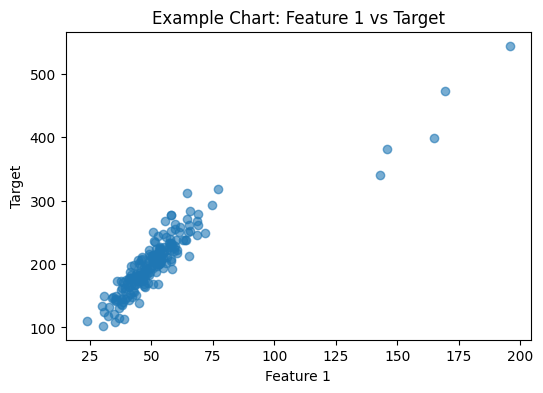

Example chart saved to outputs/example_chart.png


In [8]:
plt.figure(figsize=(6,4))
plt.scatter(df['feature_1'], df['target'], alpha=0.6)
plt.xlabel('Feature 1')
plt.ylabel('Target')
plt.title('Example Chart: Feature 1 vs Target')
example_chart_path = 'outputs/example_chart.png'
plt.savefig(example_chart_path, dpi=300)
plt.show()
print(f'Example chart saved to {example_chart_path}')

## 7) HTML Slides Generator (Reveal.js, auto-include images)

In [9]:
import textwrap

def build_html_slides(slide_titles, summary_md, output_html='outputs/decision_summary_slides.html'):
    Path('outputs').mkdir(exist_ok=True)
    images = sorted([str(p) for p in Path('outputs').glob('*.png')])
    image_section = ""
    for img in images:
        image_section += f'<section><h2>Visual</h2><img src="{img}" style="max-width:90%; margin:12px auto; display:block;" /></section>\n'

    toc_list = "".join([f"<li>{t}</li>" for t in slide_titles])


    html = textwrap.dedent(f"""\
        <!doctype html>
        <html>
        <head>
          <meta charset="utf-8">
          <title>Decision Summary Slides</title>
          <meta name="viewport" content="width=device-width, initial-scale=1.0">
          <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/reveal.js/4.5.0/reveal.min.css">
          <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/reveal.js/4.5.0/theme/white.min.css">
        </head>
        <body>
        <div class="reveal">
          <div class="slides">
            <section>
              <h1>Executive Summary</h1>
              <pre style="white-space: pre-wrap; font-size: 0.9em;">{summary_md}</pre>
            </section>
            <section>
              <h2>Outline</h2>
              <ul>{toc_list}</ul>
            </section>"""+
            str(image_section) +
        """
              </div>
            </div>
            <script src="https://cdnjs.cloudflare.com/ajax/libs/reveal.js/4.5.0/reveal.min.js"></script>
            <script>
              Reveal.initialize({ hash: true });
            </script>
            </body>
            </html>
        """)

    with open(output_html, 'w', encoding='utf-8') as f:
        f.write(html)
    return output_html

print(type(summary_md))
slides_path = build_html_slides(titles, summary_md)
slides_path

<class 'str'>


'outputs/decision_summary_slides.html'

## 8) Socratic Discussion Prompts

- Who is your stakeholder?
- What decisions are they making from your analysis?
- What would confuse or overwhelm them?
- What risks do they need to understand?
- How would your visualizations look to a non-technical audience?

## 9) Stretch Challenge Instructions
- Build your deliverable in **two formats**: one for technical peers, one for executives.
- Include one alternate scenario to show impact of assumptions.
- Explicitly highlight risks and decisions enabled by the analysis.
- Optional: include interactive charts or a mini Dash/Streamlit component for the technical audience.

## 10) Optional Dash Demo Starter

In [10]:
# Dash demo: very minimal example to show interactive plot
import dash
from dash import dcc, html
import plotly.express as px

app = dash.Dash(__name__)

fig = px.scatter(df, x='feature_1', y='target', title='Interactive Example')

app.layout = html.Div([
    html.H1('Dash Demo: Feature vs Target'),
    dcc.Graph(figure=fig)
])

# To run: uncomment the following line
app.run(debug=True, port=8000)

## 11) Pre-flight Checklist

In [11]:
from pathlib import Path

checks = {
    "Data CSV": Path("../data/raw/sample_data.csv").exists(),
    "Decision Log": Path("outputs/decision_log.json").exists() and len(decision_log.to_df())>0,
    "Executive Summary": Path("outputs/executive_summary.md").exists(),
    "Scenario Comparison Chart": Path("outputs/scenario_comparison.png").exists(),
    "Example Chart": Path("outputs/example_chart.png").exists(),
    "HTML Slides": Path("outputs/decision_summary_slides.html").exists(),
    "Images Included in Outputs": len(list(Path("outputs").glob("*.png"))) > 0
}

print("✅ Stage 12 Pre-flight Checklist ✅\n")
for item, ok in checks.items():
    status = "✅" if ok else "❌"
    print(f"{status} {item}")

if all(checks.values()):
    print("\nAll checks passed! Your notebook outputs are complete and ready for stakeholder delivery.")
else:
    print("\nSome items are missing. Please review the checklist and ensure all outputs are generated before finalizing slides.")

✅ Stage 12 Pre-flight Checklist ✅

✅ Data CSV
✅ Decision Log
✅ Executive Summary
✅ Scenario Comparison Chart
✅ Example Chart
✅ HTML Slides
✅ Images Included in Outputs

All checks passed! Your notebook outputs are complete and ready for stakeholder delivery.


In [ ]:
# Never just have your results, you want  to give the entire theory and show other reuslts to build that confidence 